In [143]:
import os
import csv
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from champion_net import ChampionNet
import torch.optim as optim
import time
import random
import matplotlib.pylab as plt
from datetime import date

#config
config = {
    'data_set': '../../data/filtered-dataset-no-header.csv',
    'model': {
        'save': True,
        'save_location': '../models',
        'layer_size': 256,
        'learning_rate': 0.0005
    },
    'batch_size': 75000,
    'epochs': 3,
    'validation_set_size': 0.2,
    'lambda2' : 0.05,
    'save_graphs': True,
    'show_graphs': True, 
    'graph_locations': '../graphs',
    'device': 'cpu'
}

device = torch.device(config['device'])

In [144]:
#training the nn functions
def forward_pass(X,y,train = False):
    if train:
        optimizer.zero_grad()
    outputs = net(X)
    matches = [(1 if i[0] > 0.5 else 0) == y[0] for i,j in zip(outputs.tolist(),y.tolist())]
   
    acc = matches.count(True)/len(matches)
    cross_entropy_loss = loss_function(outputs,y)
    all_linear2_params = torch.cat([x.view(-1) for x in net.fc2.parameters()])
    l2_regularization = lambda2 * torch.norm(all_linear2_params, 2)
    loss = cross_entropy_loss + l2_regularization
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

def test(test_X, test_y, size=32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = forward_pass(X.view(-1,154).to(device), y.to(device).view(-1, 1))
    return val_acc, val_loss

def train(train_X, train_y, net,model_name):
    log = {
        'times': [],
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': [],
    }
    for epochs in range(config['epochs']):
        for i in tqdm(range(0, len(train_X), config['batch_size'])): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:100] ..for now just to dev
            batch_X = train_X[i:i+config['batch_size']].view(-1,154)
            batch_y = train_y[i:i+config['batch_size']].view(-1, 1)
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            acc, loss = forward_pass(batch_X, batch_y, train=True)
            if i % config['batch_size'] == 0:
                val_acc, val_loss = test(test_X, test_y, size=config['batch_size'])
                log['times'].append(time.time())
                log['acc'].append(round(float(acc),2))
                log['loss'].append(round(float(loss), 4))
                log['val_acc'].append(round(float(val_acc),2))
                log['val_loss'].append(round(float(val_loss),4))
    return log

def create_acc_loss_graph(training_results, model_name, save_graphs, show_graphs):
    times = [time - training_results['times'][0] for time in training_results['times']]
    data = [training_results['acc'],training_results['loss'],training_results['val_acc'],training_results['val_loss']]
    y_labels = ['accuracy', 'loss', 'validation_accuracy', 'validation_loss']

    for i in range(len(data)):
        create_and_save_graph(times, data[i], '', y_labels[i], model_name, save_graphs, show_graphs)

def create_and_save_graph(x, y, x_label, y_label, model_name, save_graph, show_graph):
    plt.plot(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(y_label)
    if save_graph:
         plt.savefig(f"{config['model']['save_location']}/{model_name}/{y_label}.png", format='png', bbox_inches='tight')
    if show_graph:
        plt.show()


In [145]:
#useful helper functions
def convert_to_state(combination):
    res = [0 for i in range(154)] #154 champions
    for i in range(5):
        res[int(combination[i])] = 1
    
    for i in range(5, 10):
        res[int(combination[i])] = -1
    return res

def create_features_and_labels(dataset):
    features = []
    labels = []
    for point in dataset:
        feature_state = convert_to_state([int(x) for x in point[0][:10]])
        features.append(feature_state)
        blue_victory = int(point[0][10]) #1 if blue victory, 0 otherwise
        labels.append(blue_victory)
    
    return [torch.Tensor(features), torch.Tensor(labels)]

def load_data_set(filename, validation_set_size, delimiter=','):
    dataset = []
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter=delimiter)
        for row in reader:
            dataset.append(np.array([row]))


    print(f'The size of the entire dataset is {len(dataset)} points')
    val_size = int(len(dataset) * validation_set_size)

    random.shuffle(dataset)

    train_set = dataset[:-val_size]
    val_set = dataset[-val_size:]

    return [train_set, val_set ]

In [146]:
    
#Generate the validation and training sets
training_set, validation_set = load_data_set(config['data_set'], config['validation_set_size'])

train_X, train_y = create_features_and_labels(training_set)
test_X, test_y = create_features_and_labels(validation_set)

The size of the entire dataset is 984975 points


In [147]:
#declare some useful variables
layer_size = config['model']['layer_size']
lambda2 = config['lambda2']
lr = config['model']['learning_rate']
model_name = f"champion-model-{date.today().strftime('%d-%m-%Y')}-{int(time.time())}-ls{layer_size}-lr{lr}-l2{lambda2}"

In [148]:
#pytorch objects
net = ChampionNet(num_units=layer_size).to(device)

optimizer = optim.Adam(net.parameters(),lr = lr)

loss_function = nn.BCELoss()

In [149]:
#train the model
res = train(train_X, train_y, net,model_name)

100%|██████████| 11/11 [02:11<00:00, 11.99s/it]


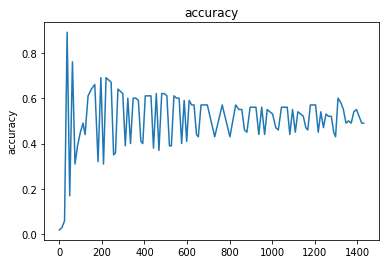

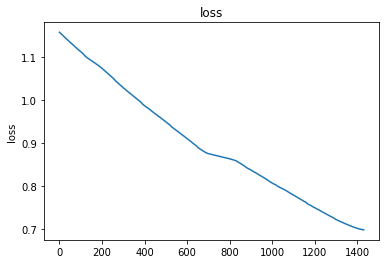

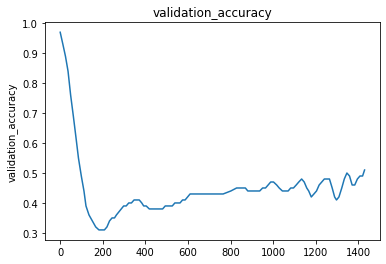

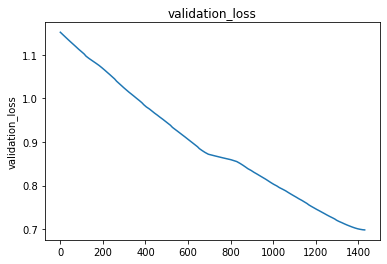

In [150]:
def save_trained_network(net, net_name, location):
    os.mkdir(f'{location}/{net_name}')
    path = f'{location}/{net_name}/model.pickle'
    torch.save(net.state_dict(), path)

#save the model, if configured to do so
if(config['model']['save']):
    save_trained_network(net, model_name, config['model']['save_location'])

#make the graphs
create_acc_loss_graph(res, model_name, config['save_graphs'], config['show_graphs'])